<a href="https://colab.research.google.com/github/danwaters/lfi/blob/main/Dan_Waters_CSCE_5218_Final_Project_(NL_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [7]:
import tensorflow as tf
from keras import preprocessing 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras.regularizers import l2
from keras.utils import np_utils

import os
import time

import matplotlib.pyplot as plt
import numpy as np

In [8]:
artist_lyrics = ['nickelback']
EPOCHS = 100
t = Tokenizer()

In [9]:
# Utility methods - plotting callback
class PlotCallback(Callback):  
  """ This is a custom class to plot every few epochs. """
  losses = []
  accs = []

  def on_train_begin(self, logs=None):
    self.losses = []
    self.accs = []

  def on_epoch_end(self, epoch, logs=None):
    loss = logs['loss']
    acc = logs['accuracy']
    self.losses.append(loss)
    self.accs.append(acc)
    epoch_checkpoints = [10, 25, 50, 100, 150]
    if epoch+1 in epoch_checkpoints:
      print(f"Snapshot at epoch {epoch+1} (loss: {loss}):")  
        
      plt.plot(self.losses)
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.title(f"Training loss at {epoch+1} epoch{'s' if epoch > 1 else 's'}")
      plt.show()

      plt.plot(self.accs)
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.title(f"Training accuracy at {epoch+1} epoch{'s' if epoch > 1 else 's'}")
      plt.show()

  def on_train_end(self, logs=None):
    print(f"Minimum loss: {min(self.losses)} (epoch {np.argmin(self.losses) + 1})")
    self.losses = []
    self.accs = []

In [10]:
# Text generation
def generate_text(model, max_sequence_length, seed_text="she", next_words=100, sequence_word_length=6):
  """ This method generates next_words words based on the seed text by
  repeatedly feeding the last sequence_length words into the LSTM to make the
  prediction. It keeps track of every word generated and prints the result."""
  # Seed and run predictions
  total_text = seed_text

  for i in range(next_words):
    token_list = t.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], 
                               maxlen=max_sequence_length - 1,
                               padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in t.word_index.items():
      if index == predicted:
        output_word = word
        break
    total_text += " " + output_word
    seed_text = seed_text + " " + output_word
 
    # if seed_text is n words or more, drop the first word in the sequence.
    seed_words = seed_text.split(' ')
    if len(seed_words) >= sequence_word_length:
      seed_text = ' '.join(seed_words[1:])

  out = ""
  for i, w in enumerate(total_text.split(' ')):
    out = out + " " + w
    if i % sequence_word_length == 0 and i > 0: # insert line breaks every 5 words
      out += "\r\n"

  print(out) 
  print("--------------------------------------\r\n")

**Method C: Bi-directional LSTM with Word Embeddings**

This was the preferred method selected in the experimentation phase. This is the cleaned up version of the original notebook.

Based on: https://towardsdatascience.com/nlp-text-generation-through-bidirectional-lstm-model-9af29da4e520

In [11]:
# https://towardsdatascience.com/nlp-text-generation-through-bidirectional-lstm-model-9af29da4e520
# Tokenize input on words
def train_artist_lyrics(artist):
  print(f"\r\n*** Training {artist} ... ***")

  text = open(artist + ".txt", 'rb').read().decode(encoding='utf-8')

  # kill the newlines and lowercase everything
  sentences = text.lower().replace("\r\n", "\n").split("\n")

  # fit the tokenizer
  t.fit_on_texts(sentences)
  total_words = len(t.word_index) + 1
  
  print(f"There are {total_words} unique words in {artist}.txt")

  # Create input sequences, using list of tokens
  input_sequences = []
  for sentence in sentences:
    word_list = t.texts_to_sequences([sentence])[0]
    for i in range(1, len(word_list)):
      n_gram_sequence = word_list[:i+1] # include next
      input_sequences.append(n_gram_sequence)

  # Pad the sequences to fill in zeroes to maximum dimensionality 
  max_sequence_length = max([len(x) for x in input_sequences]) 
  input_sequences = np.array(pad_sequences(input_sequences, 
                                           maxlen=max_sequence_length, 
                                           padding='pre'))
  
  # Get predictors and categorical label
  predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
  label = tf.keras.utils.to_categorical(label, num_classes=total_words)

  # Build the bi-directional LSTM
  model = Sequential()
  model.add(Embedding(total_words, 100, input_length=max_sequence_length-1))
  model.add(Bidirectional(LSTM(150, return_sequences = True)))
  model.add(Dropout(0.2))
  model.add(LSTM(100))
  model.add(Dense(total_words/2, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(Dense(total_words, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())

  # Configure checkpointing
  checkpoint_dir = f'./training_checkpoints/{artist}'
  checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
  checkpoint_callback = ModelCheckpoint(filepath=checkpoint_prefix, 
                                        save_weights_only=True)

  # Fit the model
  history = model.fit(predictors, label, epochs=EPOCHS, verbose=1, callbacks=[checkpoint_callback, PlotCallback()])
  
  # SAVE THE FREAKING MODELS
  save_path = f'saved_models/{artist}_lyrics'
  model.save(save_path)
  print(f'Model saved to {save_path}.')
  
  # Print the results. 
  print(f'Here are your new {artist.upper()} lyrics.\r\n*****\r\n')
  generate_text(model, max_sequence_length, seed_text="i")

  

**DO IT!**


*** Training nickelback ... ***
There are 2065 unique words in nickelback.txt
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 29, 100)           206500    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 29, 300)           301200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 300)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 1032)              104232    
_________________________________________________________________
dense_5 (Dense)              (None, 2065)              2133145   
Total params: 2,905,477
Trainable params:

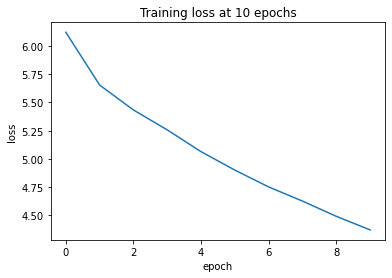

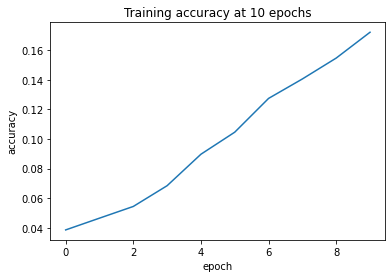

Epoch 11/100
787/787 [==============================] - 12s 15ms/step - loss: 4.2475 - accuracy: 0.1882
Epoch 12/100
787/787 [==============================] - 12s 15ms/step - loss: 4.1380 - accuracy: 0.2058
Epoch 13/100
787/787 [==============================] - 12s 15ms/step - loss: 4.0451 - accuracy: 0.2118
Epoch 14/100
787/787 [==============================] - 12s 15ms/step - loss: 3.9619 - accuracy: 0.2250
Epoch 15/100
787/787 [==============================] - 12s 15ms/step - loss: 3.8341 - accuracy: 0.2490
Epoch 16/100
787/787 [==============================] - 12s 15ms/step - loss: 3.7379 - accuracy: 0.2650
Epoch 17/100
787/787 [==============================] - 12s 15ms/step - loss: 3.6324 - accuracy: 0.2827
Epoch 18/100
787/787 [==============================] - 12s 15ms/step - loss: 3.5688 - accuracy: 0.2934
Epoch 19/100
787/787 [==============================] - 12s 16ms/step - loss: 3.4824 - accuracy: 0.3030
Epoch 20/100
787/787 [==============================] - 12s 15ms

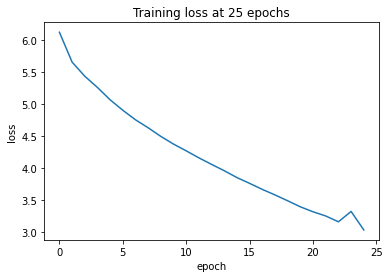

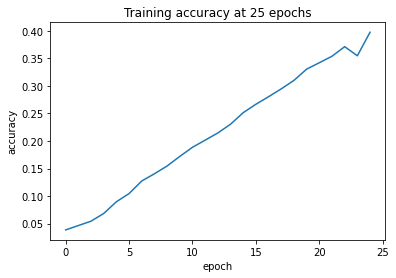

Epoch 26/100
787/787 [==============================] - 12s 16ms/step - loss: 2.9253 - accuracy: 0.4144
Epoch 27/100
787/787 [==============================] - 12s 16ms/step - loss: 2.8414 - accuracy: 0.4337
Epoch 28/100
787/787 [==============================] - 12s 15ms/step - loss: 2.7949 - accuracy: 0.4415
Epoch 29/100
787/787 [==============================] - 12s 16ms/step - loss: 2.7340 - accuracy: 0.4572
Epoch 30/100
787/787 [==============================] - 12s 16ms/step - loss: 2.6585 - accuracy: 0.4707
Epoch 31/100
787/787 [==============================] - 12s 15ms/step - loss: 2.6147 - accuracy: 0.4793
Epoch 32/100
787/787 [==============================] - 12s 16ms/step - loss: 2.5414 - accuracy: 0.4999
Epoch 33/100
787/787 [==============================] - 12s 15ms/step - loss: 2.4791 - accuracy: 0.5102
Epoch 34/100
787/787 [==============================] - 12s 16ms/step - loss: 2.4366 - accuracy: 0.5146
Epoch 35/100
787/787 [==============================] - 12s 16ms

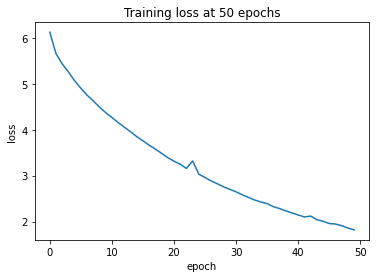

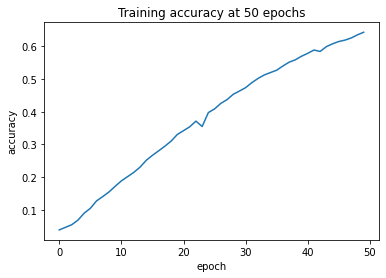

Epoch 51/100
787/787 [==============================] - 12s 15ms/step - loss: 1.7798 - accuracy: 0.6550
Epoch 52/100
787/787 [==============================] - 12s 15ms/step - loss: 1.7497 - accuracy: 0.6584
Epoch 53/100
787/787 [==============================] - 12s 15ms/step - loss: 1.7082 - accuracy: 0.6693
Epoch 54/100
787/787 [==============================] - 12s 16ms/step - loss: 1.6699 - accuracy: 0.6768
Epoch 55/100
787/787 [==============================] - 12s 15ms/step - loss: 1.6443 - accuracy: 0.6846
Epoch 56/100
787/787 [==============================] - 12s 16ms/step - loss: 1.6243 - accuracy: 0.6905
Epoch 57/100
787/787 [==============================] - 12s 16ms/step - loss: 1.6456 - accuracy: 0.6816
Epoch 58/100
787/787 [==============================] - 12s 16ms/step - loss: 1.6042 - accuracy: 0.6930
Epoch 59/100
787/787 [==============================] - 12s 16ms/step - loss: 1.5543 - accuracy: 0.7016
Epoch 60/100
787/787 [==============================] - 12s 15ms

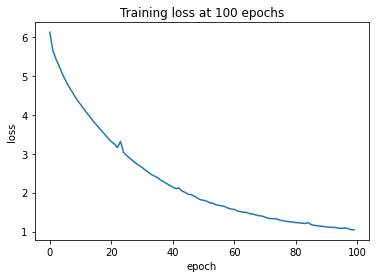

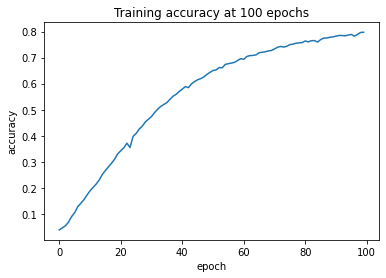

Minimum loss: 1.0411044359207153 (epoch 100)


INFO:tensorflow:Assets written to: saved_models/nickelback_lyrics/assets


INFO:tensorflow:Assets written to: saved_models/nickelback_lyrics/assets


Model saved to saved_models/nickelback_lyrics.
Here are your new NICKELBACK lyrics.
*****

 i miss you so so i do
 to still come around you wreck
 with you had a lighthouse from
 fire we'll all stay skinny 'cause
 we can't go by it better
 laugh is a believer in hand
 in my ass 'cause i guess
 i should've listened of this morning
 all of this all of this
 life what i'm callin' and swallowed
 their pride and you know you
 know you know you know you
 know you know you know you
 know you know you know you
 know you know you know you
 know you know you know you
 know you know you
--------------------------------------



In [12]:
for artist in artist_lyrics:
  train_artist_lyrics(artist)